In [27]:
import sys
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [28]:
N=50
q=0.05
G=nx.erdos_renyi_graph(N,q)

In [29]:
# directed graph with weighted edges (https://networkx.org/documentation/stable/reference/classes/generated/networkx.Graph.add_weighted_edges_from.html)

G = nx.DiGraph()  # or DiGraph, MultiGraph, MultiDiGraph, etc
G.add_weighted_edges_from([(0, 1, 3.0), (1, 2, 7.5)])

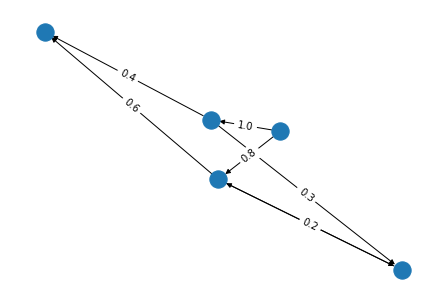

In [30]:
# https://stackoverflow.com/questions/56597840/drawing-weighted-graph-from-adjacency-matrix-with-edge-labels
# Directed weighted graph from weighted Adjacency Matric (matrix C in J. Lizier paper)

A = [
    [0, 1,  0,  .8, 0],
    [0, 0,  .4, 0,  .3],
    [0, 0,  0,  0,  0],
    [0, 0,  .6, 0,  .7],
    [0, 0,  0,  .2, 0]]

G = nx.from_numpy_matrix(np.matrix(A), create_using=nx.DiGraph)
layout = nx.spring_layout(G)
nx.draw(G, layout)
#nx.draw_networkx_edge_labels(G, pos=layout)
labels = nx.get_edge_attributes(G, "weight")
nx.draw_networkx_edge_labels(G, pos=layout, edge_labels=labels)
plt.show()

In [37]:
edges_attributes_dict_keys = next(iter(G.edges(data=True)))[2].keys()
edges_attributes_dict_keys

if (not 'weight' in edges_attributes_dict_keys):
    print('bla no weights')

In [36]:
nodes_attributes_dict = next(iter(G.nodes(data=True)))[1]
nodes_attributes_dict


{}

In [38]:
# Visualize weighted graph (https://networkx.org/documentation/stable/auto_examples/drawing/plot_weighted_graph.html)

def plotWeightedGraph(G: nx.DiGraph, weight_attribute='weight'):
    ''' Plot weighted graph'''

    
    elarge = [(u, v) for (u, v, d) in G.edges(data=True) if d[weight_attribute] > 5]
    esmall = [(u, v) for (u, v, d) in G.edges(data=True) if d[weight_attribute] <= 5]

    pos = nx.spring_layout(G, seed=7)  # positions for all nodes - seed for reproducibility

    # nodes
    nx.draw_networkx_nodes(G, pos, node_size=700)

    # edges
    nx.draw_networkx_edges(G, pos, edgelist=elarge, width=6)
    nx.draw_networkx_edges(G, pos, edgelist=esmall, width=6, alpha=0.5, edge_color="b", style="dashed"    )

    # node labels
    nx.draw_networkx_labels(G, pos, font_size=20, font_family="sans-serif")
    # edge weight labels
    edge_labels = nx.get_edge_attributes(G, weight_attribute)
    nx.draw_networkx_edge_labels(G, pos, edge_labels)

    ax = plt.gca()
    ax.margins(0.08)
    plt.axis("off")
    plt.tight_layout()
    plt.show()

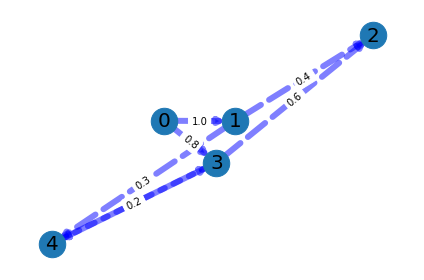

In [39]:
plotWeightedGraph(G)

In [49]:

import copy

def initialize_nodes_values(g):
    ''' setup initial x values on graph g'''
    for node in g.nodes():
        print(f'Node process initializer {node}')
        g.nodes[node]['x']=0.1

def initialize_edges_weights(g):
    for edge in g.edges():
        g.edges[edge]['weight']=0.1


class ProcessOnNetwork(): 
    def __init__(self, G):
        super().__init__()

        # Processing parameters

        # allowed_kwargs = {'initializer'}
        # for kwarg in kwargs.keys():
        #     assert kwarg in allowed_kwargs, 'Invalid keyword argument: ' + kwarg
        # initi = kwargs.get('blob')

        # properties

        self.g = copy.deepcopy(G)
        self.C = nx.to_numpy_array(G)
        self.node_initializer = initialize_nodes_values
        self.edge_weight_initializer = initialize_edges_weights
        self.N = G.number_of_nodes()
        

        # check graph has weights on its edges

        edges_attributes_dict_keys = next(iter(self.g.edges(data=True)))[2].keys()

        if (not 'weight' in edges_attributes_dict_keys):
            print('This network has no weights on its edges, initializing with random values')
            self.edge_weight_initializer(self.g)

        # initialize node values
        self.node_initializer(self.g)
        self.Xs = np.array(list(nx.get_node_attributes(self.g, 'x').values())).reshape(1,1,self.N)
            
    def initialize(self):
        self.node_initializer(self.g)

    def updateXs(self, dt=0.001, noise=True):
        # 
        N = self.N

        # take X the value of the dynamical process on each node as a row vector
        #X = np.array(nx.get_node_attributes(self.g, 'x')).reshape(1, N)
        X = self.Xs[-1]
        X.reshape(1,N)

        # Weighted adjacency matrix
        C = self.C

        # I - C
        I = np.identity(N)
        I_C = I - C

        dX = -X @ I_C * dt

        if noise==True:
            # dw Wiener process
            dW= np.sqrt(dt)*np.random.standard_normal(X.shape)
            dX = dX + dW

        Xnew = X + dX

        self.Xs = np.vstack((self.Xs,Xnew.reshape(1,1,N)))

        #nx.set_node_attributes(self.g, values=Xnew, name='x')

    def updateNetworkWitXs(self):
        nx.set_node_attributes(self.g, values=self.Xs[-1].reshape(1,N),  name='x')



In [50]:
GP = ProcessOnNetwork(G)

for _ in range(1000):
    GP.updateXs()



Node process initializer 0
Node process initializer 1
Node process initializer 2
Node process initializer 3
Node process initializer 4


In [44]:
nx.get_node_attributes(G, 'x').values()

dict_values([])

In [102]:
for _ in range(5000):
    GP.updateXs(noise=True)

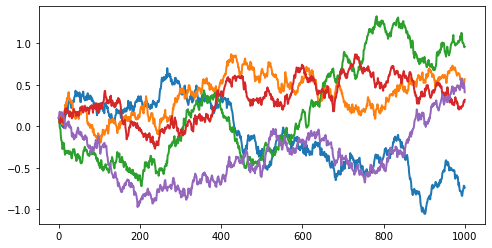

In [51]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.plot(GP.Xs[:,0,0], lw=2)
ax.plot(GP.Xs[:,0,1], lw=2)
ax.plot(GP.Xs[:,0,2], lw=2)
ax.plot(GP.Xs[:,0,3], lw=2)
ax.plot(GP.Xs[:,0,4], lw=2)

In [54]:
# Covariance X

t = 999
X = GP.Xs[t,:,:].reshape(1, GP.Xs.shape[2])  # Nodes processes values at time t
X

CovX = np.cov(X, bias=True)

print(X)

print(X.T)

print(f'Covariance X as a row {CovX}')

x_ = np.average(X)
print(f'average X {x_}')

sum=0
for i in range(X.shape[1]):
    sum+=(X[0][i] - x_)*(X[0][i] - x_)
sum=sum/X.size
print(f'Sigma calculated manually {sum}')


[[-0.72292964  0.52825121  0.9521445   0.28933648  0.48361238]]
[[-0.72292964]
 [ 0.52825121]
 [ 0.9521445 ]
 [ 0.28933648]
 [ 0.48361238]]
Covariance X as a row 0.31148366120499826
average X 0.3060829851816521
Sigma calculated manually 0.31148366120499826


In [7]:
import numpy as np

np.identity(6)


array([[1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0.]])

In [18]:
# ===========================================================================
# Averaging operator U
# https://rich-d-wilkinson.github.io/MATH3030/2-4-centering-matrix.html
# ===========================================================================

''' Centering matrix for a row vector of size N '''

getCenteringMatrix = lambda N : np.identity(N) - (1/N)*np.ones((N,N))

N = 5

C1 = np.random.rand(N,N)
print(f'C1 {C1}')

U = getCenteringMatrix(N)

print(f'U:{U}')
print(f'transpose U:{U.T}')
print(f'U_T.U:{U.T@U}')
print(f'U.U:{U@U}')


C1 [[1.14158266e-04 8.10754946e-01 8.73686734e-01 7.29749220e-01
  5.56594469e-02]
 [2.21851550e-01 9.36993849e-02 9.23109529e-01 6.66433655e-01
  3.57894596e-01]
 [2.64382972e-01 6.70369447e-01 5.39896861e-01 3.08023096e-01
  3.23272262e-01]
 [4.36074126e-01 9.68997723e-01 4.97619553e-01 8.95291927e-01
  6.28726312e-02]
 [5.41983561e-01 3.01668177e-01 1.80901975e-01 3.70189429e-02
  8.93736965e-01]]
U:[[ 0.8 -0.2 -0.2 -0.2 -0.2]
 [-0.2  0.8 -0.2 -0.2 -0.2]
 [-0.2 -0.2  0.8 -0.2 -0.2]
 [-0.2 -0.2 -0.2  0.8 -0.2]
 [-0.2 -0.2 -0.2 -0.2  0.8]]
transpose U:[[ 0.8 -0.2 -0.2 -0.2 -0.2]
 [-0.2  0.8 -0.2 -0.2 -0.2]
 [-0.2 -0.2  0.8 -0.2 -0.2]
 [-0.2 -0.2 -0.2  0.8 -0.2]
 [-0.2 -0.2 -0.2 -0.2  0.8]]
U_T.U:[[ 0.8 -0.2 -0.2 -0.2 -0.2]
 [-0.2  0.8 -0.2 -0.2 -0.2]
 [-0.2 -0.2  0.8 -0.2 -0.2]
 [-0.2 -0.2 -0.2  0.8 -0.2]
 [-0.2 -0.2 -0.2 -0.2  0.8]]
U.U:[[ 0.8 -0.2 -0.2 -0.2 -0.2]
 [-0.2  0.8 -0.2 -0.2 -0.2]
 [-0.2 -0.2  0.8 -0.2 -0.2]
 [-0.2 -0.2 -0.2  0.8 -0.2]
 [-0.2 -0.2 -0.2 -0.2  0.8]]
U.C.U:[[

In [23]:
# seems the projection of the covariance matrix AND the covariance of the projection are identical (???)

UCU = U@C1@U
print(f'U.C.U:{U@C1@U}')

covC = np.cov(C1)
print(f'cov(C) : {np.cov(C1)}')

print(f'cov(projC) {np.cov(UCU)}')

UcovCU = U@covC@U
print(f'proj(covC) : {UcovCU}')

U.C.U:[[-0.32055748  0.21386665  0.24285344  0.17465549 -0.3108181 ]
 [-0.05742493 -0.46179376  0.33367139  0.15273508  0.03281221]
 [ 0.01651531  0.14628512 -0.01813246 -0.17426666  0.02959869]
 [ 0.0372242   0.29393113 -0.21139203  0.2620199  -0.3817832 ]
 [ 0.3242429  -0.19228914 -0.34700034 -0.41514381  0.6301904 ]]
cov(C) : [[ 0.18403477  0.0677126   0.05442183  0.11600715 -0.12161428]
 [ 0.0677126   0.11453192 -0.00308013 -0.00719174 -0.05623402]
 [ 0.05442183 -0.00308013  0.0307912   0.03116875 -0.02001074]
 [ 0.11600715 -0.00719174  0.03116875  0.13633592 -0.10268908]
 [-0.12161428 -0.05623402 -0.02001074 -0.10268908  0.1132411 ]]
cov(projC) [[ 0.08364657  0.00428909 -0.00451214  0.04100516 -0.12442867]
 [ 0.00428909  0.08807309 -0.02504942 -0.04522904 -0.02208372]
 [-0.00451214 -0.02504942  0.01331146 -0.00237901  0.01862911]
 [ 0.04100516 -0.04522904 -0.00237901  0.08672015 -0.08011726]
 [-0.12442867 -0.02208372  0.01862911 -0.08011726  0.20800053]]
proj(covC) : [[ 0.08364657

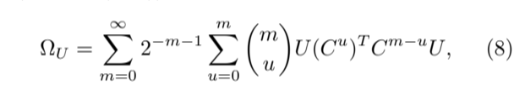

In [14]:
from IPython.display import Image
Image("omega_u.png")

In [58]:
# ===========================================================================
# Maximum relative error
# ===========================================================================

SMALL = 2.2204e-16

maxRelativeError = lambda dX, X : np.max(np.abs(dX) / np.max(np.abs(X), SMALL))

isNegligible = lambda dX, X, tolerance : np.count_nonzero((np.max(np.abs(dX)) > tolerance * SMALL * max(np.max(np.abs(X)), SMALL))) == 0

In [59]:
# ===========================================================================
# Covariance Using analytical formula
# Aim : Calculate projected covariance matrix Ω (Ω_u) that is projected into the orthogonal space to (1,1,1,1,1,...)
# https://www.dropbox.com/s/qlnx56hrtlgucxq/MotifsContributingToSync.pdf?dl=0
# ===========================================================================

'''
(1) For continuous systems

'''

def projectedCovarianceMatrix(C, tolerance=100 , max_iterations=1000):
    '''
    C : weighted adjacency matrix of our network of dynamical processes
    tolerance : tol = 100 # Multiples of machine epsilon within which we want to consider a value to be zero.
    max_iterations : maximum terms to calculate in the power series to evaluate the projected covariance matrix
    '''
    
    N = C.shape[0]
    U = getCenteringMatrix(N)

    # m = 0 first term of the series

    projM = 0.5*U # remember : U.T == U property of this thing U, and U@U == U

    # calculating terms for m=1 ==> infinity (more practically until additional term is negligible)

    leftComponent = U
    rightComponent = U
    leftMultiplier = U @ C.T
    rightMultiplier = C @ U

    for i in range(max_iterations):
        # dProjM holds the previous C'^i * C^i term
        # ProjM holds the sum of previous projected C'^i * C^i terms
        leftComponent = leftComponent @ leftMultiplier
        rightComponent = rightMultiplier @ rightComponent
        dProjM = leftComponent @ rightComponent
        if isNegligible(dProjM,projM,tolerance):
            break
        projM = projM + dProjM

    mre = maxRelativeError(dProjM, projM)

    if np.isnan(mre) or np.isinf(mre):
        print('ERROR power series calculation of projected covariance matrix failed to converge')
        return

    if i == max_iterations:
        mac = np.mean(np.mean(np.abs(ProjM)))
        print(f'WARNING power series did not converge within the maximum allowed iterations')
        return

    return projM

In [60]:
projectedCovarianceMatrix(GP.C)

TypeError: 'float' object cannot be interpreted as an integer

In [3]:
# Cholesky decomposition

# https://www.quantstart.com/articles/Cholesky-Decomposition-in-Python-and-NumPy/

import pprint
import scipy
import scipy.linalg   # SciPy Linear Algebra Library

A = scipy.array([[6, 3, 4, 8], [3, 6, 5, 1], [4, 5, 10, 7], [8, 1, 7, 25]])
L = scipy.linalg.cholesky(A, lower=True)
U = scipy.linalg.cholesky(A, lower=False)

print(f"A:{A}")
print(f"L:{L}")
print(f"U:{U}")

print(L@U)


A:[[ 6  3  4  8]
 [ 3  6  5  1]
 [ 4  5 10  7]
 [ 8  1  7 25]]
L:[[ 2.44948974  0.          0.          0.        ]
 [ 1.22474487  2.12132034  0.          0.        ]
 [ 1.63299316  1.41421356  2.30940108  0.        ]
 [ 3.26598632 -1.41421356  1.58771324  3.13249102]]
U:[[ 2.44948974  1.22474487  1.63299316  3.26598632]
 [ 0.          2.12132034  1.41421356 -1.41421356]
 [ 0.          0.          2.30940108  1.58771324]
 [ 0.          0.          0.          3.13249102]]
[[ 6.  3.  4.  8.]
 [ 3.  6.  5.  1.]
 [ 4.  5. 10.  7.]
 [ 8.  1.  7. 25.]]


/tmp/ipykernel_695/3375848548.py:9: DeprecationWarning: scipy.array is deprecated and will be removed in SciPy 2.0.0, use numpy.array instead
  A = scipy.array([[6, 3, 4, 8], [3, 6, 5, 1], [4, 5, 10, 7], [8, 1, 7, 25]])


In [121]:
GP.Xs.shape

X.shape[1]

5

In [66]:
# How to get X as a row vector from the network G

G.nodes(data=True)
for node in G.nodes():
    G.nodes[node]['x']=0.1

np.array(list(nx.get_node_attributes(G, 'x').values())).reshape(1,1,G.number_of_nodes())

array([[[0.1, 0.1, 0.1, 0.1, 0.1]]])

In [16]:
# how to initialize edges

for edge in G.edges():
    G.edges[edge]['weight']=0.1

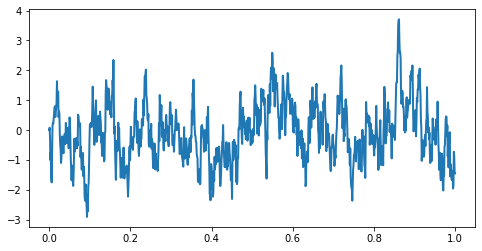

In [22]:
# https://ipython-books.github.io/134-simulating-a-stochastic-differential-equation/

dt = .001  # Time step.
T = 1.  # Total time.
n = int(T / dt)  # Number of time steps.
t = np.linspace(0., T, n)  # Vector of times.

sigma = 1.  # Standard deviation.
mu = 0.  # Mean.
tau = 0.01 #.05  # Time constant.

sigma_bis = sigma * np.sqrt(2. / tau)
sqrtdt = np.sqrt(dt)

x = np.zeros(n)

for i in range(n - 1):
    x[i + 1] = x[i] + dt * (-(x[i] - mu) / tau) + \
        sigma_bis * sqrtdt * np.random.randn()

fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.plot(t, x, lw=2)

In [25]:
# Wiener DW using Euler-Maruyama (https://ipython-books.github.io/134-simulating-a-stochastic-differential-equation/)

# 
'''

dx = a(t,x)dt + b(t,x)dw

--> discretise time 

t = n * dt

xn+1 = xn + dx = xn + a(t,xn)dt + b(t,xn) * sqrt(dt) * N(0,1)
'''

X = np.random.standard_normal((1,10))
dt=0.001
dW= np.sqrt(dt)*np.random.standard_normal(X.shape)
dW

array([[ 0.01685208,  0.0181457 , -0.01906413,  0.01151455,  0.01182954,
         0.00681198,  0.03647638, -0.00827636, -0.03311247, -0.05571611]])

In [50]:
# TEST How to stack the x(t) matrices for each nodes of the network at each time step
#-----------------------------------------------------------------------------------------

import numpy as np

array = np.array([[1,2,3],[4,5,6],[7,8,9]]).reshape(1,3,3)
print(array.shape)

# array = np.expand_dims(array, axis = 2)
# print(array.shape)

X = np.random.standard_normal((3,3)).reshape(1,3,3)
X2 = np.random.standard_normal((3,3)).reshape(1,3,3)

#array = np.stack([array,X], axis=0)
array = np.vstack((array,X))
print(array)

print(array[0])

print(array[1])
print(X2)

print("vstack -------------------------")

array = np.vstack((array,X2))

print(array[2])


(1, 3, 3)
[[[ 1.          2.          3.        ]
  [ 4.          5.          6.        ]
  [ 7.          8.          9.        ]]

 [[ 0.24502677  1.06231214 -0.50876436]
  [ 1.59247385 -1.63678404  1.00452018]
  [-0.08087132 -1.83989337  0.8403857 ]]]
[[1. 2. 3.]
 [4. 5. 6.]
 [7. 8. 9.]]
[[ 0.24502677  1.06231214 -0.50876436]
 [ 1.59247385 -1.63678404  1.00452018]
 [-0.08087132 -1.83989337  0.8403857 ]]
[[[ 2.17326051 -0.56735649  0.62690253]
  [-1.30649626  1.05531738 -0.7560109 ]
  [-0.03307711 -0.92075987 -1.53562049]]]
vstack -------------------------
[[ 2.17326051 -0.56735649  0.62690253]
 [-1.30649626  1.05531738 -0.7560109 ]
 [-0.03307711 -0.92075987 -1.53562049]]
